<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/DEIT_CLAHE_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install transformers datasets

In [3]:
!pip install torch
!pip install torchvision
import torch

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Normalize, ToTensor
from transformers import AutoFeatureExtractor, ViTForImageClassification

In [5]:
# Load pre-trained DeiT model
model = ViTForImageClassification.from_pretrained('facebook/deit-base-patch16-224')

num_classes = 3
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Feature extractor for DeiT
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-base-patch16-224')

# Define image transformations
transform = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Load dataset using ImageFolder
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder("/content/drive/MyDrive/Final_Cropped/Train", transform=transform)
val_dataset = ImageFolder("/content/drive/MyDrive/Final_Cropped/Test", transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss function
criterion = CrossEntropyLoss()

In [8]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Header for epoch tracking
print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}{'Val Accuracy':<15}")
print("-" * 50)

for epoch in range(1, 11):  # Number of epochs
    # Training loop
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch}", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / len(val_dataset)

    # Log epoch results in a tabular format
    tqdm.write(f"{epoch:<8}{train_loss:<15.4f}{val_loss:<15.4f}{val_accuracy:<15.4f}")

    scheduler.step()


Epoch   Train Loss     Val Loss       Val Accuracy   
--------------------------------------------------


1       0.4079         0.1167         0.9609         


2       0.1564         0.0852         0.9609         


3       0.1019         0.0894         0.9531         


4       0.0793         0.0466         0.9844         


5       0.0501         0.0847         0.9688         


6       0.0594         0.0902         0.9688         


7       0.0668         0.0551         0.9844         


8       0.0467         0.0569         0.9922         


9       0.0383         0.0625         0.9766         


10      0.0406         0.0676         0.9844         


In [9]:
model.eval()  # Set the model to evaluation mode
val_loss, correct = 0, 0

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

# Final loss and accuracy
val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Final Validation Pass: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Training Complete!
Final Validation Loss: 0.0595
Final Validation Accuracy: 0.9844


Final Validation Pass: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]



Training Complete!
Final Validation Loss: 0.0544
Final Validation Accuracy: 0.9844


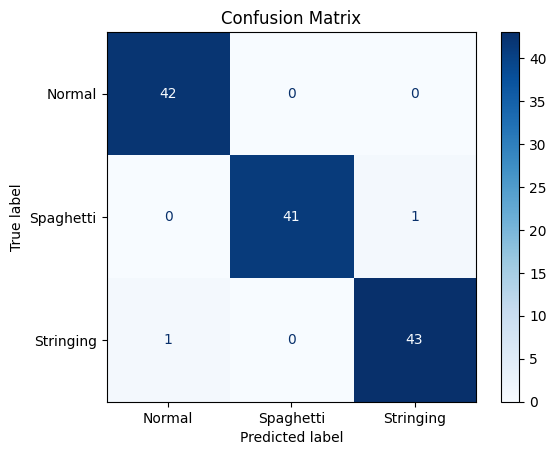

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize variables
val_loss, correct = 0, 0
all_preds = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation Pass"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        val_loss += criterion(outputs, labels).item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Final loss and accuracy
val_loss /= len(val_loader)
final_accuracy = correct / len(val_dataset)

print("\nTraining Complete!")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_loader.dataset.classes)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()
